In [1]:
%cd "fewshot-face-translation-GAN"

/home/mitho/Documents/FaceSwap/fewshot-face-translation-GAN


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from models import FaceTranslationGANInferenceModel

Using TensorFlow backend.


In [4]:
model = FaceTranslationGANInferenceModel()













Found checkpoints in weights folder. Built model with pre-trained weights.


In [5]:
from face_toolbox_keras.models.verifier.face_verifier import FaceVerifier
fv = FaceVerifier(classes=512)

from face_toolbox_keras.models.parser import face_parser
fp = face_parser.FaceParser()

from face_toolbox_keras.models.detector import face_detector
fd = face_detector.FaceAlignmentDetector()

from face_toolbox_keras.models.detector.iris_detector import IrisDetector
idet = IrisDetector()
#idet.set_detector(fd)




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [6]:
import numpy as np
from utils import utils
from matplotlib import pyplot as plt
import cv2

In [7]:
fn_src ="images/raw/34.jpg"
fn_tar ="images/raw/21.jpg"

In [8]:
def correct_colours(im1, im2):
    COLOUR_CORRECT_BLUR_FRAC=0.6
    blur_amount = COLOUR_CORRECT_BLUR_FRAC * np.linalg.norm(
                              np.mean(im1, axis=0) -
                              np.mean(im2, axis=0))
    blur_amount = int(blur_amount)
    if blur_amount % 2 == 0:
        blur_amount += 1
    im1_blur = cv2.GaussianBlur(im1, (blur_amount, blur_amount), 0)
    im2_blur = cv2.GaussianBlur(im2, (blur_amount, blur_amount), 0)

    # Avoid divide-by-zero errors.
    im2_blur += (128 * (im2_blur <= 1.0)).astype(im2_blur.dtype)

    result= (im2.astype(np.float64) * im1_blur.astype(np.float64) /
                                                im2_blur.astype(np.float64))
    result = np.clip(result, 0, 255).astype(np.uint8)
    return result

In [9]:
src, mask, aligned_im, (x0, y0, x1, y1), landmarks,M = utils.get_src_inputs(fn_src, fd, fp, idet)
tar, emb_tar = utils.get_tar_inputs(fn_tar, fd, fv)


Building FAN for landmarks detection...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Done.


In [10]:
def increase_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

In [11]:
tar=cv2.resize(tar, (src.shape[1], src.shape[0]))
tar=correct_colours(src,tar)

In [12]:
out = model.inference(src, mask, tar, emb_tar)


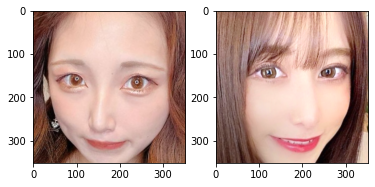

In [13]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(src)
plt.subplot(1,2,2)
plt.imshow(tar)

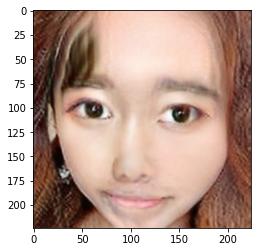

In [14]:
result_face = np.squeeze(((out[0] +1) * 255/2).astype(np.uint8))
plt.imshow(result_face)


In [15]:
result_face=cv2.resize(result_face, (src.shape[1], src.shape[0]))
# result_face=correct_colours(src,result_face)

rst=result_face


In [16]:
# a,b = np.where(np.all(mask==[0,0,255],axis=2))
# result_face[a,b]=src[a,b]
# a,b = np.where(np.all(mask==[0,255,255],axis=2))
# result_face[a,b]=src[a,b]
from utils.faceswap import FaceSwap
fs=FaceSwap()
trs=fs.transform(src,result_face)

if type(trs)!=int:    
    result_face=trs
    cv2.imwrite("dummy.jpg",result_face)
    result_face=cv2.imread("dummy.jpg")
    result_face=increase_brightness(result_face,value=10)
  
    
    mouth=cv2.imread("mouth.png")
    a,b = np.where(np.all(mouth!=[0,0,0],axis=2))
    src=correct_colours(trs,src)
    result_face[a,b]=src[a,b]
    a,b = np.where(np.all(mask==[255, 75, 125],axis=2))
    result_face[a,b]=rst[a,b]
   
    blur = cv2.GaussianBlur(result_face,(3,3),0)
#     blur=increase_brightness(blur,value=10)
    a,b = np.where(np.all(mask==[0,0,255],axis=2))
    result_face[a,b]=blur[a,b]
    
 
    
    

True

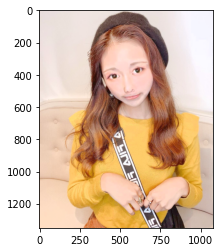

In [17]:
result_img = utils.post_process_result(fn_src, fd, result_face, aligned_im, src, x0, y0, x1, y1, landmarks,M)
# dummy_img = utils.post_process_result(fn_src, fd, dummy_face, aligned_im, src, x0, y0, x1, y1, landmarks,M)
# result_img=result_img.astype('float32')
result_img=increase_brightness(result_img,value=20)
plt.imshow(result_img)        
result_img = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)
kernel = np.array([[-0.8, -0.5,.8],
            [0.5, 3, -0.5],
            [-.5, -0.5, -0.5]])
dst = cv2.filter2D(result_img,-1,kernel)
cv2.imwrite("images/results/result_im_1.jpg",dst)